In [1]:
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

# visualize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_formats = {'png', 'retina'}
# import japanize_matplotlib

# generate data

In [2]:
def gen_two_norm(N:int,
                 prior:float,
                 frac_labeled:float,
                 random_state=42):
    # 二次元正規分布を2つ用意してそこからデータを生成する
    # N ... 生成する総データ数. >=100
    # prior ... サンプル内の真のPositiveの割合
    # frac_labeled ... p(observed=Positive|true=Positive) (=1-p(observed=Unlabeled | true=Positive))
    assert N>99 , 'too small'
    assert 0<prior<1 and 0<frac_labeled<1
    np.random.seed(random_state)
    
    # まず真のデータの生成
    NP = int(N*prior)
    NN = N-NP
    mean_P=(1,1)
    cov_P=((1,0),(0,1))
    mean_N=(-1,-1)
    cov_N=((1,0),(0,1))
    
    positives=np.random.multivariate_normal(mean_P,cov_P,size=NP)
    negatives=np.random.multivariate_normal(mean_N,cov_N,size=NN)
    X=np.vstack([positives, negatives])
    y_true=np.array([1]*NP + [-1]*NN)
    
    y_observed=np.array([1]*NP + [0]*NN)
    y_observed[:NP]=np.random.binomial(1, frac_labeled, NP)

    return X, y_true, y_observed

In [3]:
X,y_true,y_observed=gen_two_norm(3000,0.5,0.5)

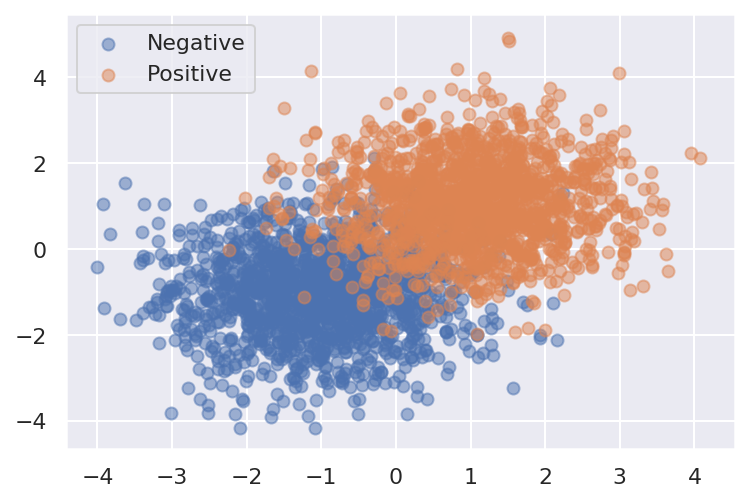

In [4]:
plt.scatter(X[y_true==-1,0], X[y_true==-1,1],alpha=0.5, color='C0', label='Negative')
plt.scatter(X[y_true==1,0], X[y_true==1,1],alpha=0.5, color='C1', label='Positive')
plt.legend();

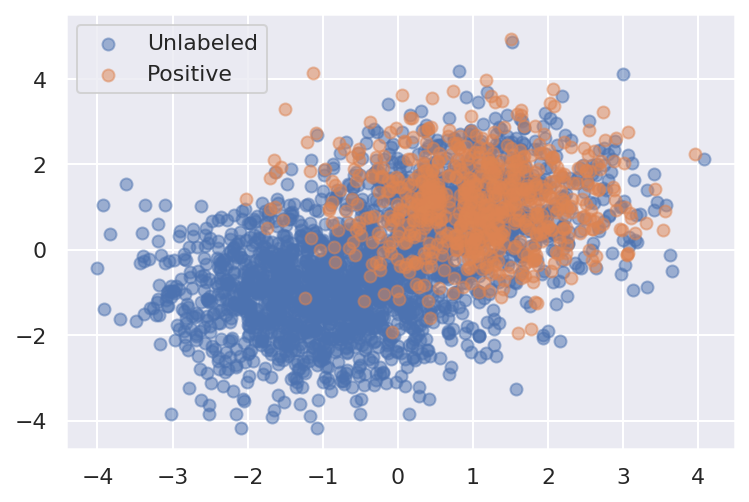

In [5]:
plt.scatter(X[y_observed==0,0], X[y_observed==0,1],alpha=0.5, color='C0', label='Unlabeled')
plt.scatter(X[y_observed==1,0], X[y_observed==1,1],alpha=0.5, color='C1', label='Positive')
plt.legend();

# prepare train, valid, test

In [6]:
X_train,X_valid,\
y_observed_train,y_observed_valid,\
y_true_train,y_true_valid=\
train_test_split(X, y_observed, y_true,
                 test_size=0.2,random_state=42)
X_test, y_true_test, _=gen_two_norm(1000,0.5,0.5)

# if we can use y_true

In [7]:
def get_accuracy(y_true, predict_score):
    pred=(predict_score>0).astype(int)
    pred[pred==0]=-1
    return (y_true == pred).sum()/y_true.shape[0]

In [8]:
gbm=LGBMRegressor(objective='regression',
                  random_state=42,
                  learning_rate=0.01,
                  n_estimators=10000)

gbm.fit(X_train,y_true_train,
        eval_metric='l2',
        eval_set=[(X_valid, y_true_valid)],
        early_stopping_rounds=10,
        verbose=False  )

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=10000, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=42, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [9]:
get_accuracy(y_true_test, gbm.predict(X_test))

0.917

#  if we let unlabeled as negative

In [10]:
y_observed_train_u_as_n = y_observed_train.copy()
y_observed_train_u_as_n[y_observed_train==0] = -1 #unlabeled as negative
y_observed_valid_u_as_n = y_observed_valid.copy()
y_observed_valid_u_as_n[y_observed_valid==0] = -1

In [11]:
gbm=LGBMRegressor(objective='regression',
                  random_state=42,
                  learning_rate=0.01,
                  n_estimators=10000)

gbm.fit(X_train,y_observed_train_u_as_n,
        eval_metric='l2',
        eval_set=[(X_valid, y_observed_valid_u_as_n)],
        early_stopping_rounds=10,
        verbose=False)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=10000, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=42, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [12]:
get_accuracy(y_true_test, gbm.predict(X_test))

0.582

# define custom objective


when y_observed==1
$$l_{pu}(y_{observed}, y_{pred})= -\frac{\pi}{n^P} y_{pred} + \frac{1}{4n} (y_{pred}+1)^2$$

$$\frac{\partial}{\partial y_{pred}} l_{pu}(y_{observed}, y_{pred})= -\frac{\pi}{n^P} + \frac{1}{2n} (y_{pred}+1)$$

$$ \frac{\partial^2}{\partial y_{pred} ^2} l_{pu}(y_{observed}, y_{pred})= \frac{1}{2n}$$

when y_observed==0
$$l_{pu}(y_{observed}, y_{pred})= \frac{1}{4n} (y_{pred}+1)^2$$

$$\frac{\partial}{\partial y_{pred}} l_{pu}(y_{observed}, y_{pred})= \frac{1}{2n} (y_{pred}+1)$$

$$ \frac{\partial^2}{\partial y_{pred} ^2} l_{pu}(y_{observed}, y_{pred})= \frac{1}{2n}$$


`pu_sl` is equal to $l_{pu}$

In [13]:
def pu_sl(y_observed, y_pred, prior:float):
    N=y_observed.shape[0]
    NP=(y_observed==1).sum()
    mask=y_observed==1
    #loss
    loss=1/(4*N) * (y_pred+1)**2
    tmp= -prior/NP * y_pred
    loss[mask] += tmp[mask]
    #grad
    grad=1/(2*N) * (y_pred+1)
    grad[mask] -= prior/NP
    #hess
    hess=1/(2*N) * np.ones_like(grad)
    return loss, grad, hess

In [14]:
def custom_objective(y_observed, y_pred):
    prior=0.5
    loss, grad, hess=pu_sl(y_observed, y_pred, prior)
    return grad, hess

def custom_eval(y_observed, y_pred):
    prior=0.5
    loss, grad, hess=pu_sl(y_observed, y_pred, prior)
    return 'pu_sl', loss.sum(), False

# PU learning

In [15]:
gbm=LGBMRegressor(objective=custom_objective,
                  random_state=42,
                  learning_rate=0.01,
                  n_estimators=10000)

gbm.fit(X_train,y_observed_train,
        eval_metric=custom_eval,
        eval_set=[(X_valid, y_observed_valid)],
        early_stopping_rounds=10,
        verbose=False)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=10000, n_jobs=-1, num_leaves=31,
              objective=<function custom_objective at 0x7fb7df8c3680>,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [16]:
get_accuracy(y_true_test, gbm.predict(X_test))

0.903